In [3]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import scipy.stats as ss
from scipy.optimize import curve_fit
plt.rc("font", family=["Helvetica", "Arial"]) # skifter skrifttype
plt.rc("axes", labelsize=22)   # skriftstørrelse af `xlabel` og `ylabel`
plt.rc("xtick", labelsize=22, top=True, direction="out")
plt.rc("ytick", labelsize=22, right=True, direction="out")
plt.rc("axes", titlesize=22)
plt.rc("legend", fontsize=18)
plt.rcParams["figure.figsize"] = (8, 6)

In [12]:
def flatten_array(arr):
    flattened = []
    for sub in arr[:]:
        flattened = np.concatenate((flattened, sub))
    return flattened
def reject_outliers(data, x, m=5):
    idxs = abs(data - np.mean(data)) < m * np.std(data)
    return data[idxs], x[idxs]
def gaussian(x, amplitude, mean, standard_deviation):
    return amplitude * np.exp( - (x - mean)**2 / (2*standard_deviation ** 2))
def t_stats_tracks_in_vtxs(vertex_tracks_idx, track_t):
    avg_ts = []
    rms_ts = []
    for i, event in enumerate(vertex_tracks_idx):
        event_avg_t = []
        event_rms_t = []
        for vertex_tracks in event:
            if len(vertex_tracks) > 0:
                ts = np.array(track_t[i][vertex_tracks])
                avg_t = np.mean(ts)
                rms_t = np.sqrt(np.mean(ts**2))
                event_avg_t.append(avg_t)
                event_rms_t.append(rms_t)
        avg_ts.append(event_avg_t)
        rms_ts.append(event_rms_t)
    return np.array(avg_ts, dtype='object'), np.array(rms_ts, dtype='object')

In [23]:
file = uproot.open("OutDir_1/hist-Rel21sample.root")
tree1 = file['EventTree;1']
track_t = tree1['track_t'].array(library='np')
track_t_flat = flatten_array(track_t)

reco_vertex_track_idxs = tree1['recovertex_tracks_idx'].array(library='np')

avg_ts, rms_ts = t_stats_tracks_in_vtxs(reco_vertex_track_idxs, track_t)

(0.0, 0.5)

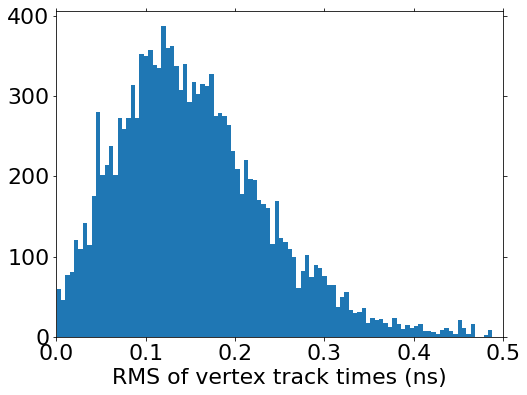

In [31]:
t_range = 0.5

_ = plt.hist(flatten_array(rms_ts)[np.abs(flatten_array(rms_ts)) < t_range], bins = 100)

plt.xlabel('RMS of vertex track times (ns)')
plt.xlim(0, t_range)

(-0.4, 0.4)

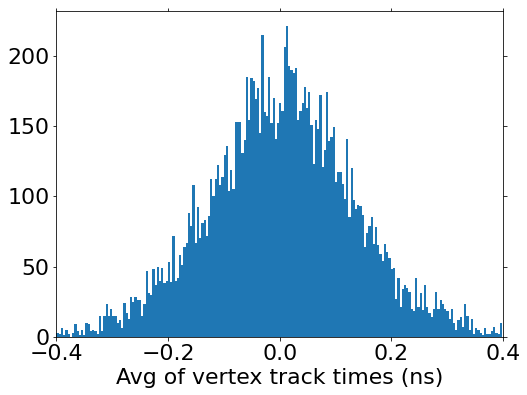

In [32]:
t_range = 0.4

_ = plt.hist(flatten_array(avg_ts)[np.abs(flatten_array(avg_ts)) < t_range], bins = 200)

plt.xlabel('Avg of vertex track times (ns)')
plt.xlim(-t_range, t_range)

In [ ]:
#More data!
#Also look at track times for jet collections